In [1]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch as pt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score


In [9]:
from pathlib import Path

len(list(Path("../../../acts/open_ended_truth_acts/Llama3/8B/chat/").iterdir()))

3

### Load data
Rows in the `activations` must correspond to those in `label_df`

In [10]:
tensors = []
datasets = []
for i, dset_dir in enumerate(Path("../../../acts/open_ended_truth_acts/Llama3/8B/chat/").iterdir()):
    dset_name = dset_dir.name
    try:
        datasets.append(pd.read_csv(f"../../../datasets/open_ended_truth/{dset_name}.csv"))
    except Exception as e:
        print(f"../../datasets/{dset_name}.csv")
        continue
    
    for file in sorted(dset_dir.iterdir(), key=lambda file_: int(str(file_).split("_")[-1].split(".")[0])):
        if "layer_12" not in str(file):
            continue
        tensors.append(pt.load(file))
        
    # if i < 10 or i > 15:
    #     continue


In [11]:
activations = pt.cat(tensors, axis=0).to("cpu")

In [12]:
(activations.element_size() * activations.nelement()) / 1e6 # Size in mb of the tensor

34.209792

In [15]:
label_df = pd.concat([d["label"] for d in datasets], axis=0).reset_index(drop=True).to_frame()
label_df

,label
0,1
1,0
2,0
3,0
4,1
...,...
2083,0
2084,1
2085,0
2086,1


In [16]:
# label_df = pd.read_csv("../../datasets/animal_class.csv")
label_df["correct"] = label_df["label"].astype(bool)

In [17]:
dataset_size = activations.shape[0]
dataset_size

2088

In [19]:
activation_dims = activations.shape[-1]

### PCA just to visualise if nice clusters dominate
Don't worry if they don't at this stage, we might still get nice separation

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(activations)

pca = PCA(n_components=2)
pca_activations = pca.fit_transform(X_scaled)

<Axes: >

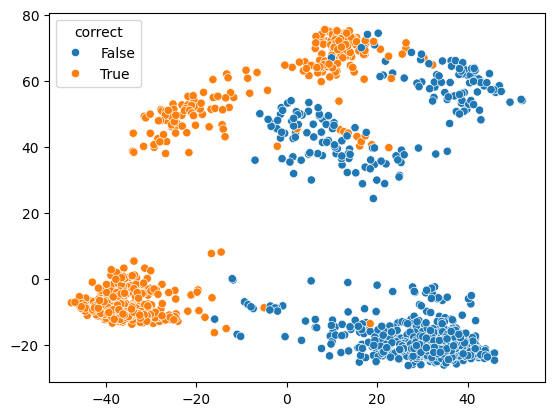

In [23]:
sns.scatterplot(x=pca_activations[:, 0], y=pca_activations[:, 1], hue=label_df["correct"])

### Calculate "correctness" direction
The further along this vector, the more correct the answer should be 🤞

In [24]:
# activation = mu + sign * correctness_direction where mu is the mean of all activations (the centroid) and sign is -1 if incorrect and 1 if correct
# Basically the centroid over the data + the correctness direction (or it flipped) should take you to the centroid of the class.

mu = activations.mean(axis=0)

s = pt.ones(dataset_size)
s[~label_df["correct"]] = -1 # those that are incorrect should point in the opposite direction

correctness_direction = pt.mean((activations - mu) * s[:, None], dim=0) # From algebra should be /s, but x/1=x*1 and x/-1=x*-1 so can just multiply by s
correctness_direction

tensor([ 0.0186,  0.0101, -0.0108,  ..., -0.0451,  0.0430,  0.0297])

In [25]:
correctness_end_pca = pca.transform(scaler.transform(correctness_direction[None, :])).squeeze()
correctness_end_pca

array([-28.48339155,  49.82073169])

In [26]:
zero_pca = pca.transform(scaler.transform([[0]*4096])).squeeze()
correctness_direction_pca = correctness_end_pca - zero_pca # need to transform the begining and end of the vector so that we transform the vector so that we can get the difference in pca space.

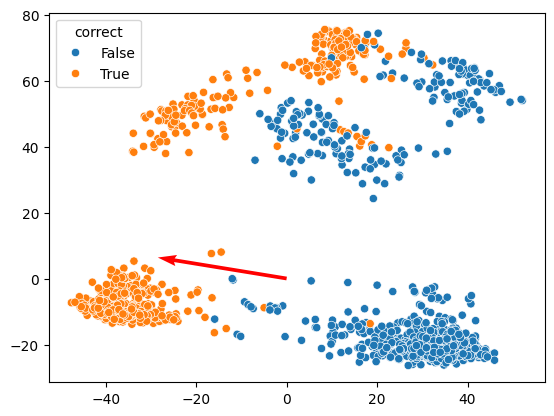

In [27]:
ax = sns.scatterplot(x=pca_activations[:, 0], y=pca_activations[:, 1], hue=label_df["correct"])
ax.quiver(0, 0, correctness_direction_pca[0], correctness_direction_pca[1], 
          angles='xy', scale_units='xy', scale=1,
          color='red', label='Correctness Direction')
ax.legend

### Evaluate using this direction as a classifier
Finds the ideal point to slice along this direction

In [ ]:
def evaluate_classification(labels, correctness):
    df = pd.DataFrame({"label": labels, "correctness": correctness})

    fpr, tpr, thresholds = roc_curve(df["label"], df["correctness"])
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]
    print(f"{optimal_threshold=}")

    ax = sns.histplot(df[~df["label"]]["correctness"], label="Incorrect")
    ax = sns.histplot(df[df["label"]]["correctness"], label="Correct", ax=ax)
    ax.axvline(optimal_threshold, color='red', linestyle='--', label='Optimal Threshold {optimal_threshold}')
    ax.legend()
    plt.show()

    acc = accuracy_score(label_df["correct"], label_df["correctness"] > optimal_threshold)
    print(f"Accuracy score {acc}")

    roc_auc = auc(fpr, tpr)
    print(f"{roc_auc=}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


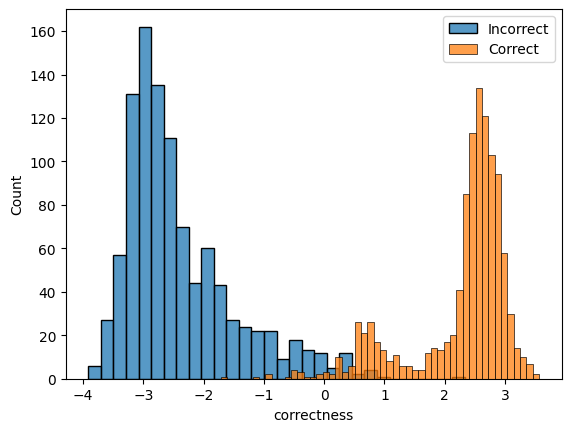

In [28]:
label_df["correctness"] = ((activations - mu) @ correctness_direction)
evaluate_classification(label_df["correct"], label_df["correctness"])

### Train an MLP as a classifier for comparison

In [32]:
train_indices = np.random.uniform(0, 1, dataset_size) < 0.8
test_indices = ~train_indices

train_label_df = label_df.iloc[train_indices]
test_label_df = label_df.iloc[test_indices]

In [33]:
import torch.nn as nn
import torch.optim as optim

class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_size, output_size):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        return self.fc2(nn.functional.relu(self.fc(x)))

model = SingleLayerPerceptron(activation_dims, 1)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(activations[train_indices])
    
    # Convert targets to float tensor
    targets = pt.tensor(train_label_df["correct"].to_numpy(), dtype=pt.float32)
    
    # Ensure outputs match target shape
    outputs = outputs.squeeze()
    
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

/workspace/Truth_is_Universal/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/100], Loss: 0.6939
Epoch [11/100], Loss: 0.6843
Epoch [21/100], Loss: 0.6754
Epoch [31/100], Loss: 0.6664
Epoch [41/100], Loss: 0.6567
Epoch [51/100], Loss: 0.6463
Epoch [61/100], Loss: 0.6356
Epoch [71/100], Loss: 0.6243
Epoch [81/100], Loss: 0.6123
Epoch [91/100], Loss: 0.5994


In [34]:
test_label_df["mlp_classifier_pred"] = nn.functional.sigmoid(model(activations[test_indices])).detach().numpy().squeeze()
test_label_df

/tmp/ipykernel_90631/2426868929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dummy_data["mlp_classifier_pred"] = nn.functional.sigmoid(model(activations[test_indices])).detach().numpy().squeeze()


,label,correct,correctness,mlp_classifier_pred
4,1,True,2.372155,0.562674
8,1,True,-0.019492,0.504375
10,1,True,0.506108,0.516827
16,1,True,0.630921,0.517896
20,1,True,0.675205,0.517982
...,...,...,...,...
2075,0,False,-3.316338,0.424235
2076,1,True,2.570117,0.571032
2078,1,True,2.781455,0.575295
2083,0,False,-2.844201,0.434401


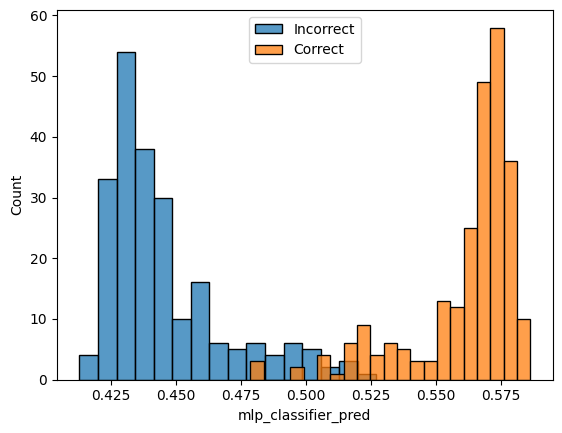

In [35]:
evaluate_classification(test_label_df["correct"], test_label_df["mlp_classifier_pred"])